In [13]:
!pip install opencv-python
!pip install seaborn
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 38.3 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 4.8 MB/s eta 0:00:00a 0:00:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 8.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 56.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 55.0 MB/s eta 0:00:

In [14]:
!pip install brevitas

Defaulting to user installation because normal site-packages is not writeable


In [15]:
import os
import random
import pathlib
import warnings
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import brevitas.nn as qnn
from brevitas.core.quant import QuantType
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat, Int8Bias

warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data path
data_path = "/home/vitis/finn/notebooks/kaggle/input/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

# Prepare dataset
def load_dataset(data_path):
    images = []
    labels = []
    for subfolder in os.listdir(data_path):
        subfolder_path = os.path.join(data_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)
    return pd.DataFrame({'image': images, 'label': labels})

data = load_dataset(data_path)
train_df, dummy_df = train_test_split(data, train_size=0.80, shuffle=True, stratify=data['label'], random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, stratify=dummy_df['label'], random_state=123)

# Define Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_indices=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_indices = class_indices

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        image = Image.open(img_path).convert('RGB')
        label = self.class_indices[self.dataframe.iloc[idx]['label']]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Create datasets and loaders
class_indices = {label: idx for idx, label in enumerate(train_df['label'].unique())}
train_dataset = CustomDataset(train_df, transform=transform, class_indices=class_indices)
valid_dataset = CustomDataset(valid_df, transform=transform, class_indices=class_indices)
test_dataset = CustomDataset(test_df, transform=transform, class_indices=class_indices)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Define quantized MobileNetV2 model with better output layers
from brevitas.quant_tensor import QuantTensor

class QuantMobileNetV2Model(nn.Module):
    def __init__(self, num_classes=4):
        super(QuantMobileNetV2Model, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        self.base_model.features[0][0] = qnn.QuantConv2d(3, 32, kernel_size=3, stride=2, padding=1, weight_bit_width=8, bias_quant=Int8Bias, weight_quant=Int8WeightPerTensorFloat)
        self.base_model.features[0][1] = qnn.QuantReLU(quant_type=QuantType.INT, bit_width=8)
        
        # Replace all Conv2d and ReLU layers with quantized versions
        for i, layer in enumerate(self.base_model.features):
            if isinstance(layer, nn.Conv2d):
                self.base_model.features[i] = qnn.QuantConv2d.from_float(layer, weight_bit_width=8, bias_quant=Int8Bias, weight_quant=Int8WeightPerTensorFloat)
            elif isinstance(layer, nn.ReLU):
                self.base_model.features[i] = qnn.QuantReLU(quant_type=QuantType.INT, bit_width=8)
                
        self.base_model.classifier[1] = nn.Sequential(
            nn.Linear(self.base_model.last_channel, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Instantiate model and set device
quant_mobilenetv2_model = QuantMobileNetV2Model(num_classes=4).to(device)

# Define loss and optimizer
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

optimizer = optim.Adam(quant_mobilenetv2_model.parameters(), lr=0.001)
criterion = FocalLoss()

In [13]:
# Training function with early stopping
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    best_valid_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # Wrap images in QuantTensor
            quant_images = QuantTensor(images, scale=1.0, bit_width=8)
            optimizer.zero_grad()
            outputs = model(quant_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                # Wrap images in QuantTensor
                quant_images = QuantTensor(images, scale=1.0, bit_width=8)
                outputs = model(quant_images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_loss = running_loss / len(valid_loader)
        valid_accuracy = correct / total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_quant_mobilenetv2_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping!")
                break

    return train_losses, valid_losses, train_accuracies, valid_accuracies

# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(quant_mobilenetv2_model, train_loader, valid_loader, criterion, optimizer, num_epochs=20, patience=5)


Epoch [1/20], Train Loss: 0.0327, Train Accuracy: 0.8873, Valid Loss: 0.0090, Valid Accuracy: 0.9647
Epoch [2/20], Train Loss: 0.0103, Train Accuracy: 0.9589, Valid Loss: 0.0213, Valid Accuracy: 0.9301
Epoch [3/20], Train Loss: 0.0043, Train Accuracy: 0.9849, Valid Loss: 0.0033, Valid Accuracy: 0.9880
Epoch [4/20], Train Loss: 0.0046, Train Accuracy: 0.9837, Valid Loss: 0.0220, Valid Accuracy: 0.9269
Epoch [5/20], Train Loss: 0.0029, Train Accuracy: 0.9877, Valid Loss: 0.0030, Valid Accuracy: 0.9888
Epoch [6/20], Train Loss: 0.0010, Train Accuracy: 0.9968, Valid Loss: 0.0053, Valid Accuracy: 0.9896
Epoch [7/20], Train Loss: 0.0035, Train Accuracy: 0.9870, Valid Loss: 0.0035, Valid Accuracy: 0.9888
Epoch [8/20], Train Loss: 0.0048, Train Accuracy: 0.9838, Valid Loss: 0.0038, Valid Accuracy: 0.9831
Epoch [9/20], Train Loss: 0.0031, Train Accuracy: 0.9887, Valid Loss: 0.0057, Valid Accuracy: 0.9807
Epoch [10/20], Train Loss: 0.0034, Train Accuracy: 0.9901, Valid Loss: 0.0045, Valid Accura

In [15]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Wrap images in QuantTensor
            quant_images = QuantTensor(images, scale=1.0, bit_width=8)
            outputs = model(quant_images)  # Use quantized images
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

# Evaluate the model
test_loss, test_accuracy = evaluate_model(quant_mobilenetv2_model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.0024, Test Accuracy: 0.9880


In [17]:
import time

# Function to measure execution time
#def measure_time(func, *args, **kwargs):
    #start_time = time.time()  # Start time
    #result = func(*args, **kwargs)  # Call the function
    #end_time = time.time()  # End time
    #execution_time = end_time - start_time  # Calculate execution time
    #return result, execution_time  # Return result and execution time

# Train the model and measure execution time
#train_results, train_time = measure_time(train_model, 
                                          #quant_mobilenetv2_model, 
                                          #train_loader, 
                                          #valid_loader, 
                                          #criterion, 
                                          #optimizer, 
                                          #num_epochs=20, 
                                          #patience=5)

#print(f'Training Time: {train_time:.2f} seconds')

# Evaluate the model and measure execution time
test_results, test_time = measure_time(evaluate_model, quant_mobilenetv2_model, test_loader)

print(f'Evaluation Time: {test_time:.2f} seconds')

Evaluation Time: 22.22 seconds


In [25]:
import time  # Import time module for CPU timing

def measure_inference_metrics(model, dataloader):
    model.eval()
    total_time = 0.0
    total_images = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            quant_images = QuantTensor(images, scale=1.0, bit_width=8)

            # Measure inference time
            start_time = time.time()
            outputs = model(quant_images)
            elapsed_time = time.time() - start_time

            total_time += elapsed_time
            total_images += images.size(0)

            # Memory usage
            memory_allocated = torch.cuda.memory_allocated() / (1024 * 1024) if torch.cuda.is_available() else 0  # MB
            memory_reserved = torch.cuda.memory_reserved() / (1024 * 1024) if torch.cuda.is_available() else 0  # MB

    avg_inference_time = (total_time / total_images) * 1000 if total_images > 0 else 0  # Convert to milliseconds
    throughput = (total_images / total_time) if total_time > 0 else 0  # images per second
    memory_usage = memory_allocated

    return avg_inference_time, throughput, memory_usage


In [26]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Wrap images in QuantTensor
            quant_images = QuantTensor(images, scale=1.0, bit_width=8)
            outputs = model(quant_images)  # Use quantized images
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

# Measure metrics during evaluation
avg_inference_time, throughput, memory_usage = measure_inference_metrics(quant_mobilenetv2_model, test_loader)

# Evaluate the model
test_loss, test_accuracy = evaluate_model(quant_mobilenetv2_model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
print(f'Average Inference Time: {avg_inference_time:.4f} ms, Throughput: {throughput:.2f} images/s, Memory Usage: {memory_usage:.2f} MB')

Test Loss: 0.0080, Test Accuracy: 0.9671
Average Inference Time: 9.1057 ms, Throughput: 109.82 images/s, Memory Usage: 0.00 MB


In [27]:
num_epochs= 20

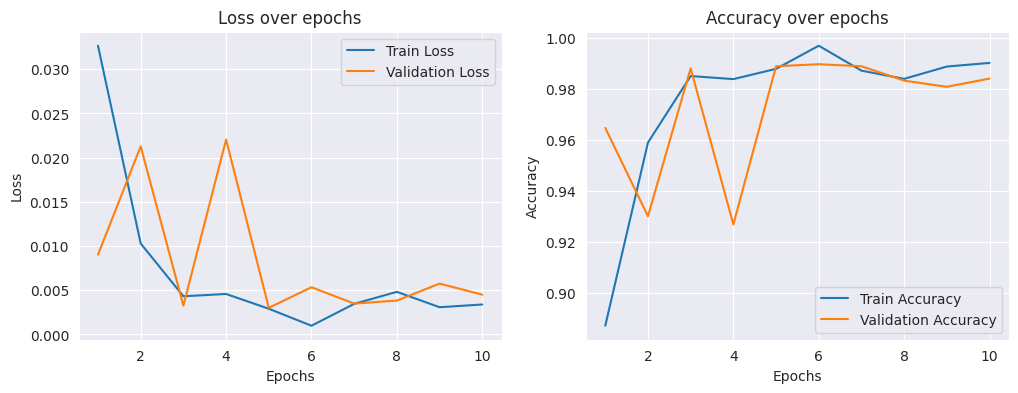

In [28]:
# Plotting function
def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot metrics
plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies, num_epochs)

In [29]:
# Load best model for inference
quant_mobilenetv2_model.load_state_dict(torch.load('best_quant_mobilenetv2_model.pth'))

<All keys matched successfully>

In [31]:
def display_predictions(model, data_loader, class_indices):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    # Create QuantTensor from images
    quant_images = QuantTensor(images, scale=1.0, bit_width=8)

    outputs = model(quant_images)  # Use quantized images
    _, predicted = torch.max(outputs, 1)
    
    # Plot images with predicted labels
    plt.figure(figsize=(15, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu())
        plt.title(f'True: {list(class_indices.keys())[labels[i]]}\nPred: {list(class_indices.keys())[predicted[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

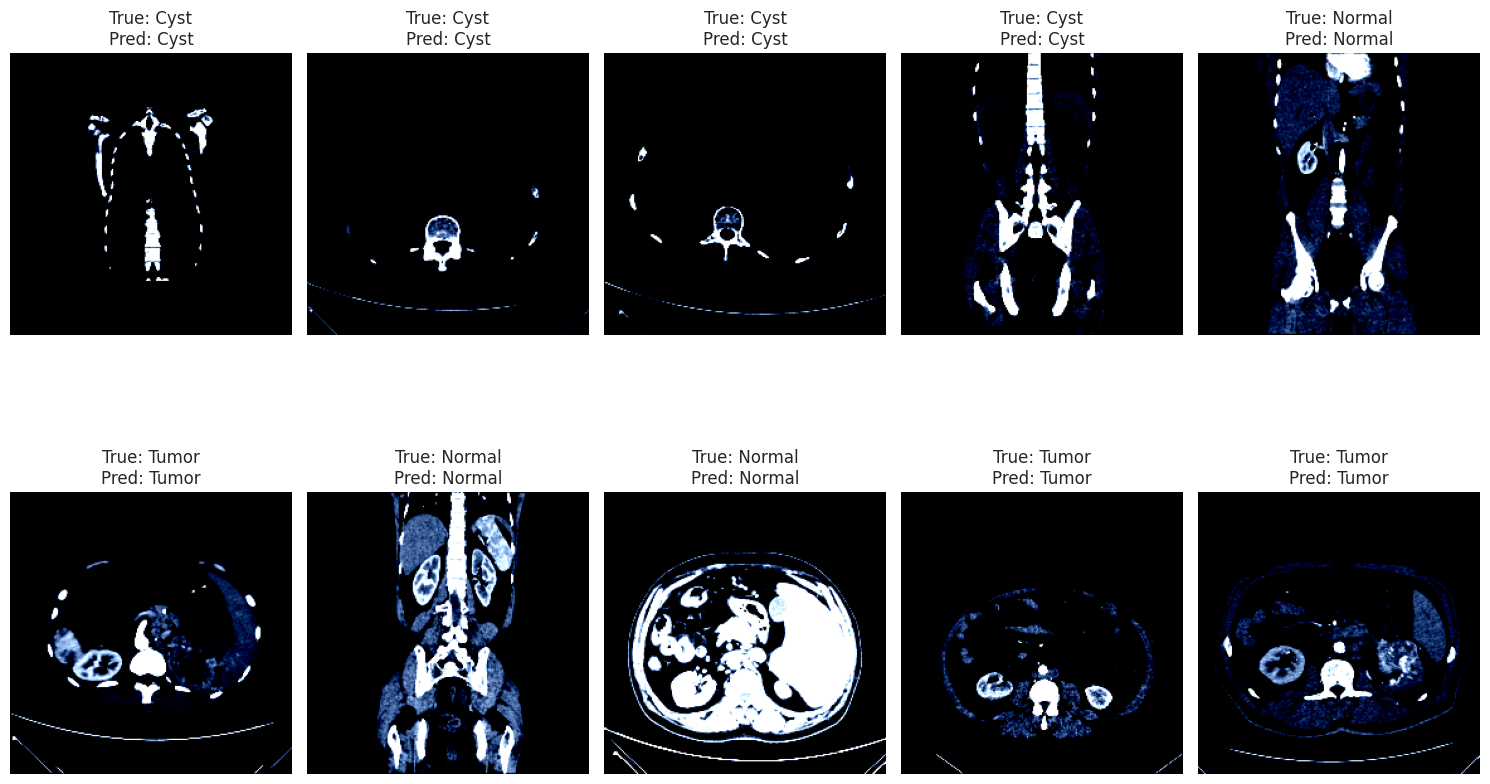

In [32]:
# Display predictions
display_predictions(quant_mobilenetv2_model, test_loader, class_indices)

In [34]:
def evaluate_model(model, test_loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Wrap images in QuantTensor
            quant_images = QuantTensor(images, scale=1.0, bit_width=8)
            outputs = model(quant_images)  # Use quantized images
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    
    return y_true, y_pred, test_loss, test_accuracy

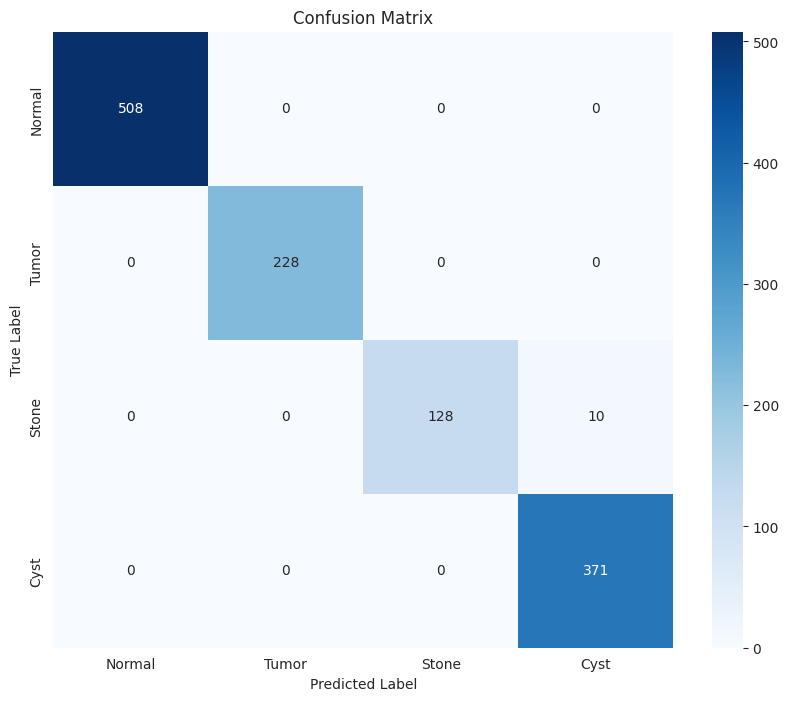

In [35]:
# Evaluate the model and get true and predicted labels
y_true, y_pred, test_loss, test_accuracy = evaluate_model(quant_mobilenetv2_model, test_loader)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=list(class_indices.keys()), columns=list(class_indices.keys()))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [53]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from brevitas.quant_tensor import QuantTensor  # Ensure you have this import

# Assuming device is already defined in your previous code
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to preprocess and predict on a single image
def predict_image(image_path, model, transform, class_indices):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Preprocess the image and move to device

    with torch.no_grad():
        # Wrap image in QuantTensor if using quantized model
        quant_image = QuantTensor(image, scale=1.0, bit_width=8)  # Only if using quantized model
        output = model(quant_image)  # Pass quantized image to the model
        probabilities = F.softmax(output, dim=1).cpu().numpy()[0]  # Get probabilities
        predicted_class = np.argmax(probabilities)  # Get predicted class index
        predicted_label = list(class_indices.keys())[predicted_class]  # Get predicted label

    return predicted_label, probabilities




Predicted Label: Tumor
Normal: 0.78%
Tumor: 99.05%
Stone: 0.00%
Cyst: 0.17%


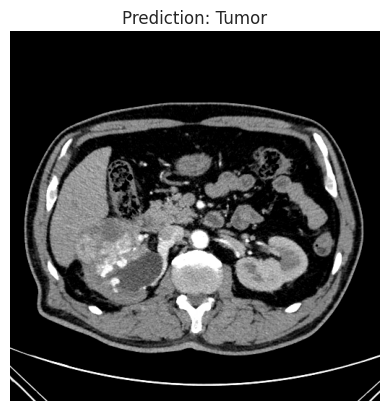

In [54]:
# Define a function to display the prediction results
def display_prediction(image_path, model, transform, class_indices):
    predicted_label, probabilities = predict_image(image_path, model, transform, class_indices)
    
    print(f'Predicted Label: {predicted_label}')
    for label, probability in zip(class_indices.keys(), probabilities):
        print(f'{label}: {probability:.2%}')  # Display probabilities as percentages

    # Display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Prediction: {predicted_label}')
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage: Upload and predict an image
uploaded_image_path = '/home/vitis/finn/notebooks/pic1.jpg'  # Replace this with the actual image path

# Assuming 'mobilenetv2_model', 'transform', and 'class_indices' are already defined
display_prediction(uploaded_image_path, quant_mobilenetv2_model, transform, class_indices)

Predicted Label: Stone
Normal: 0.01%
Tumor: 0.00%
Stone: 99.90%
Cyst: 0.09%


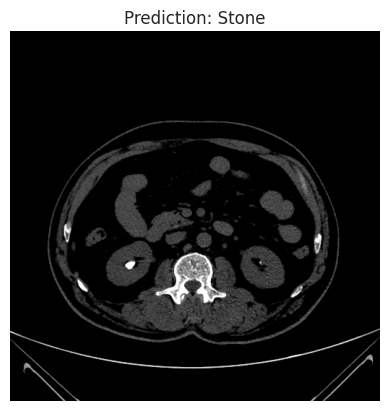

In [55]:
uploaded_image_path = '/home/vitis/finn/notebooks/pic2s.jpg'  # Replace this with the actual image path
display_prediction(uploaded_image_path, quant_mobilenetv2_model, transform, class_indices)

Predicted Label: Normal
Normal: 99.98%
Tumor: 0.02%
Stone: 0.00%
Cyst: 0.00%


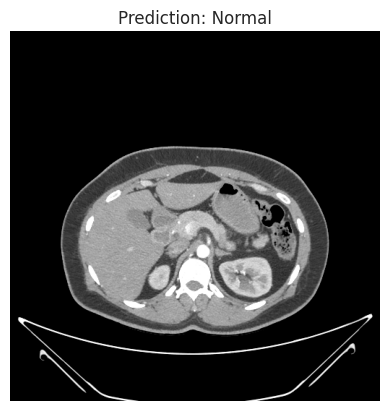

In [56]:
uploaded_image_path = '/home/vitis/finn/notebooks/pic3n.jpg'  # Replace this with the actual image path
display_prediction(uploaded_image_path, quant_mobilenetv2_model, transform, class_indices)

Predicted Label: Cyst
Normal: 0.00%
Tumor: 0.01%
Stone: 3.12%
Cyst: 96.87%


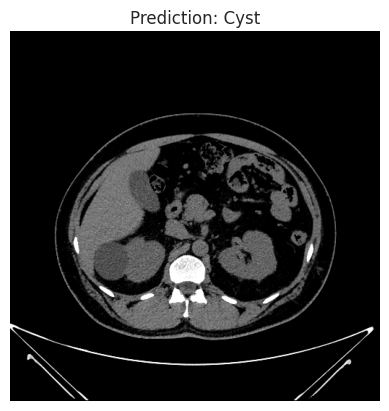

In [57]:
uploaded_image_path = '/home/vitis/finn/notebooks/pic4c.jpg'  # Replace this with the actual image path
display_prediction(uploaded_image_path, quant_mobilenetv2_model, transform, class_indices)

# Step 1: Export the Quantized Model to ONNX

After evaluating the quantized model, we'll export it to ONNX format.

In [16]:
import torch.nn as nn
import brevitas.nn as qnn
from torchvision import transforms, models
class QuantMobileNetV2Model(nn.Module):
    def __init__(self, num_classes=4):
        super(QuantMobileNetV2Model, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        self.base_model.features[0][0] = qnn.QuantConv2d(3, 32, kernel_size=3, stride=2, padding=1, weight_bit_width=8, bias_quant=Int8Bias, weight_quant=Int8WeightPerTensorFloat)
        self.base_model.features[0][1] = qnn.QuantReLU(quant_type=QuantType.INT, bit_width=8)
        
        # Replace all Conv2d and ReLU layers with quantized versions
        for i, layer in enumerate(self.base_model.features):
            if isinstance(layer, nn.Conv2d):
                self.base_model.features[i] = qnn.QuantConv2d.from_float(layer, weight_bit_width=8, bias_quant=Int8Bias, weight_quant=Int8WeightPerTensorFloat)
            elif isinstance(layer, nn.ReLU):
                self.base_model.features[i] = qnn.QuantReLU(quant_type=QuantType.INT, bit_width=8)
                
        self.base_model.classifier[1] = nn.Sequential(
            nn.Linear(self.base_model.last_channel, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Instantiate model and set device
quant_mobilenetv2_model = QuantMobileNetV2Model(num_classes=4).to(device)

quant_mobilenetv2_model.load_state_dict(torch.load('best_quant_mobilenetv2_model.pth'))

<All keys matched successfully>

In [20]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
import numpy as np
import torch

ready_model_filename = "quant_mobilenetv2.onnx"
input_shape = (3, 224, 224)

# create a QuantTensor instance to mark input as bipolar during export
input_a = np.random.randint(0, 1, size=input_shape).astype(np.uint8)
#input_a = 2 * input_a - 1
input_t = torch.from_numpy(input_a * input_scale)

#dummy_input = torch.randn(1, 3, 224, 224).to(device)
#input_t = (dummy_input / input_scale + input_zero_point).clamp(0, 255).to(torch.uint8)

#Move to CPU before export
#model_for_export.cpu()

# Export to ONNX
export_qonnx(
    quant_mobilenetv2_model, export_path=ready_model_filename, input_t=input_t
)

# clean-up
qonnx_cleanup(ready_model_filename, out_file=ready_model_filename)

# ModelWrapper
model = ModelWrapper(ready_model_filename)
# Setting the input datatype explicitly because it doesn't get derived from the export function
model.set_tensor_datatype(model.graph.input[0].name, DataType["BIPOLAR"])
model = model.transform(ConvertQONNXtoFINN())
model.save(ready_model_filename)

print("Model saved to %s" % ready_model_filename)

RuntimeError: Input scale required

In [60]:
import torch

# Assuming quant_mobilenetv2_model is your quantized model
# and that it's already in eval mode.

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Perform a forward pass to get the quantization parameters
with torch.no_grad():
    quantized_input = quant_mobilenetv2_model.quantization_config.input_quantization_config
    input_scale = quantized_input.scale
    input_zero_point = quantized_input.zero_point

# Prepare the input tensor with scale and zero-point
input_tensor = (dummy_input / input_scale + input_zero_point).clamp(0, 255).to(torch.uint8)

# Export the model to ONNX
onnx_export_path = "quant_mobilenetv2.onnx"
torch.onnx.export(
    quant_mobilenetv2_model,
    input_tensor,
    onnx_export_path,
    verbose=True,
    opset_version=11,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},  # variable length axes
        "output": {0: "batch_size"},
    },
)
print("Model exported successfully!")


AttributeError: 'QuantMobileNetV2Model' object has no attribute 'quantization_config'

In [58]:
import torch.onnx

# Export the model to ONNX
dummy_input = torch.randn(1, 3, 224, 224).to(device)
onnx_export_path = "quant_mobilenetv2.onnx"
torch.onnx.export(quant_mobilenetv2_model, dummy_input, onnx_export_path, verbose=True, opset_version=11)

RuntimeError: Input scale required